In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import networkx as nx
import math
import json
import plotly.express as px
import pandas as pd
import numpy as np

## 1. Load nodes and edges from JSON file

In [2]:
nodes = json.load(open('./genshin_data/node_list.json', 'rb'))
edges = json.load(open('./genshin_data/edge_list.json', 'rb'))

In [3]:
 # example look of the node_list JSON file
nodes[1]

{'id': 'Keqing', 'nation': 'Liyue'}

In [4]:
# example look of the edge_list JSON file
edges[1]

{'type': 'voice', 'from': 'Amber', 'to': 'Klee'}

In [5]:
%%time

# create directed graph
directed_graph = nx.DiGraph()

# add characters with a nation attribute
for node in nodes:
    directed_graph.add_node(node['id'], nation=node['nation'])

# add character relations
for edge in edges:
    directed_graph.add_edge(edge['from'], edge['to'], type=edge['type'])

Wall time: 1e+03 µs


In [6]:
# basic node and edge stats from networkx
print("Number of nodes:", directed_graph.number_of_nodes())
print("Number of edges:", directed_graph.number_of_edges())

Number of nodes: 35
Number of edges: 262


### In the Genshin Impact character network, we have 35 character nodes and 262 connections.

In [42]:
# setting node colours for drawing
nation_color_dict = {
    'Mondstadt': '#aff8db',
    'Liyue': '#ffcbc1',
    'Inazuma': '#d5aaff',
    'Snezhnaya': '#ace7ff'
}

# for each node, assign the node a color based on the
# the color map dictionary if the nation is existed in 
# the color map dictionary
node_colors = []
for node, nation in list(directed_graph.nodes(data="nation")):
    if nation in nation_color_dict:
        node_colors.append(nation_color_dict[nation])
    else:
        node_colors.append('#FFA500') # traveler doesn't belong to any nation

In [51]:
def plot_genshin_network(graph, node_colors, legend_tiles,
                         title="Genshin Impact Character Social Network"):
    # create spring layout for 25 iterations to separate the nodes
    np.random.seed(2021)
    pos = nx.spring_layout(graph, k=0.3, iterations=25)

    plt.figure(1,figsize=(15,15)) 
    nx.draw(graph,
            pos = pos,
            node_size=2000,
            node_color=node_colors,
            with_labels=True,
            font_size = 11,
            font_color='black')

    plt.title(title)
    plt.legend(handles=legend_tiles, loc="upper left")
    plt.show()

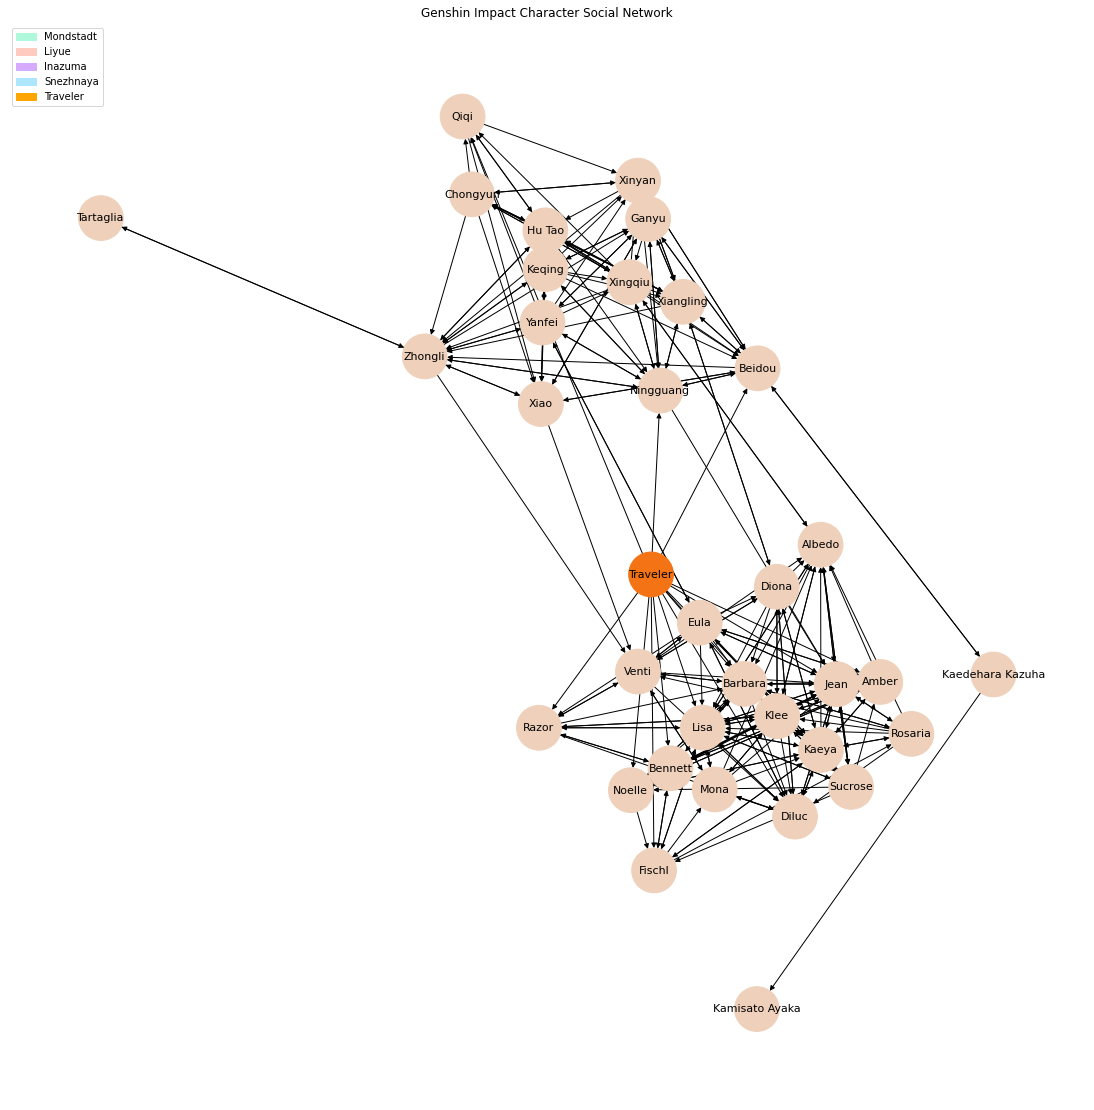

Wall time: 2.05 s


In [52]:
%%time

legend_tiles = [mpatches.Patch(color="#aff8db", label="Mondstadt"),
                mpatches.Patch(color="#ffcbc1", label="Liyue"),
                mpatches.Patch(color="#d5aaff", label="Inazuma"),
                mpatches.Patch(color="#ace7ff", label="Snezhnaya"),
                mpatches.Patch(color="#FFA500", label="Traveler"),
               ]
plot_genshin_network(directed_graph, node_colors, legend_tiles,
                     title="Genshin Impact Character Social Network")
# uncomment to save picture
# plt.savefig('directed.png')

## Description Statistics:

## 2. Centrality / Node Importance
What characterizes an important node?

### 2.1 Degree centrality (local importance)

1. Assumption: important nodes have many connections.
2. Definition: measure node n’s importance by the degree of node n over total number of nodes
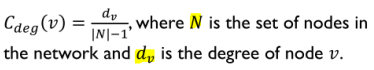
3. Interpretation: which node is the most important one with the most number of connections/friends/followers?

### Since the graph is directed, we will have in-degree and out-degree centrality.

In [18]:
in_degree_centrality_df = pd.DataFrame(nx.in_degree_centrality(directed_graph).items(), 
                                       columns=["node", "in_degree_centrality"])
in_degree_centrality_df.sort_values("in_degree_centrality", ascending=False).head(10)

,node,in_degree_centrality
34,Jean,0.500000
24,Lisa,0.441176
5,Kaeya,0.382353
6,Klee,0.382353
10,Diluc,0.352941
19,Barbara,0.323529
4,Zhongli,0.323529
16,Albedo,0.323529
15,Beidou,0.294118
12,Ningguang,0.294118


### Jean has the highest in-degree centrality. This implies Jean is mostly mentioned by other character in their storyline and voice memo.

In [46]:
# for a given graph and an important node,
# return suitable node color list for visualization
def get_centrality_node_colors(graph, important_node):
    node_colors = ["#EFD1BB"] * len(graph.nodes())
    node_colors[list(graph.nodes()).index(important_node)] = "#F47315"
    return node_colors

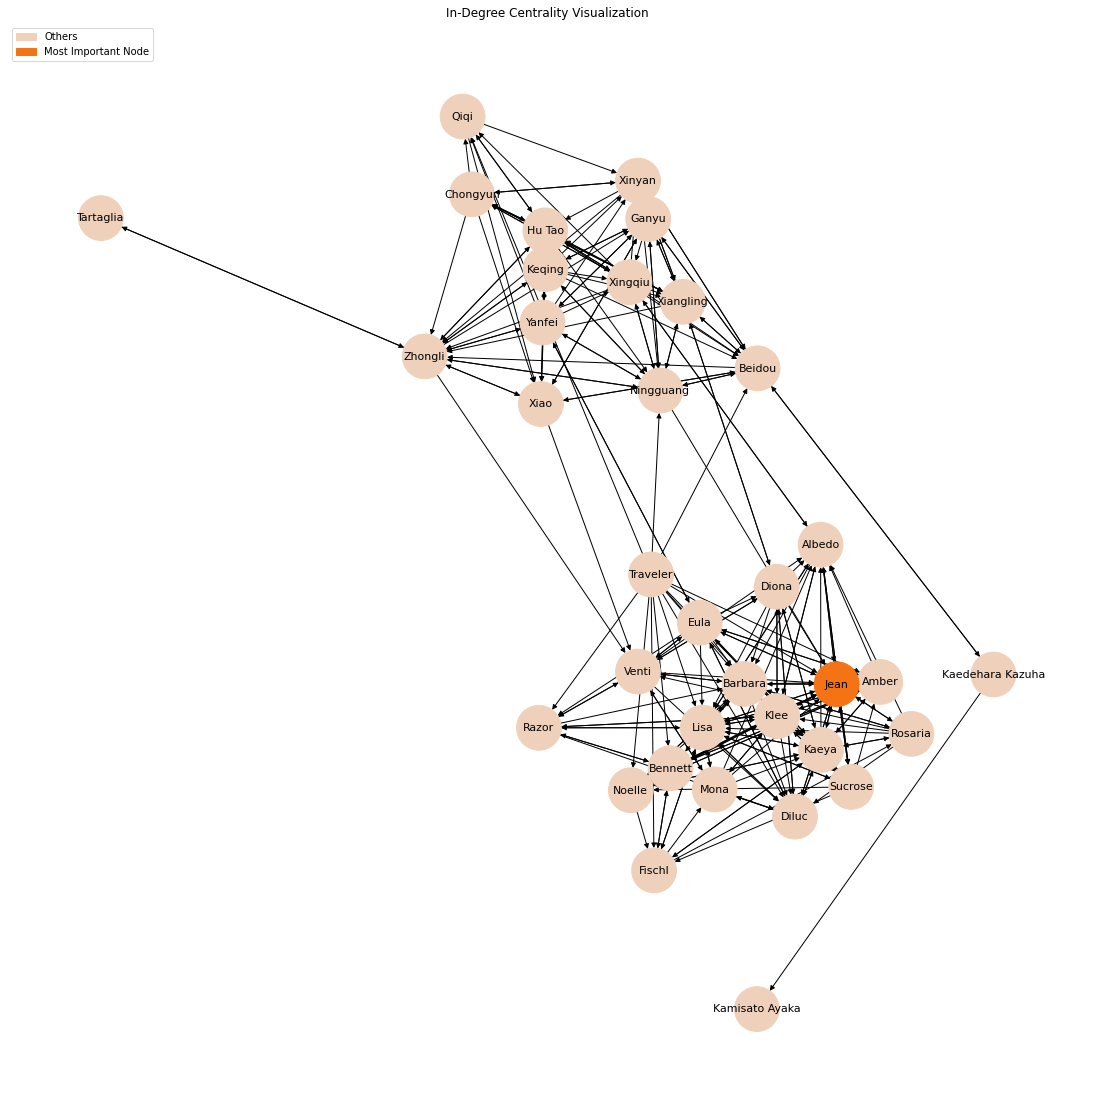

Wall time: 1.95 s


In [54]:
%%time
legend_tiles = [mpatches.Patch(color="#EFD1BB", label="Others"),
                mpatches.Patch(color="#F47315", label="Most Important Node")
               ]
node_colors = get_centrality_node_colors(directed_graph, "Jean")
plot_genshin_network(directed_graph, node_colors, legend_tiles,
                     title="In-Degree Centrality Visualization")

In [19]:
out_degree_centrality_df = pd.DataFrame(nx.out_degree_centrality(directed_graph).items(), 
                                       columns=["node", "out_degree_centrality"])
out_degree_centrality_df.sort_values("out_degree_centrality", ascending=False).head(10)

,node,out_degree_centrality
25,Traveler,0.411765
24,Lisa,0.352941
34,Jean,0.323529
5,Kaeya,0.323529
6,Klee,0.323529
14,Eula,0.323529
1,Keqing,0.264706
29,Diona,0.264706
8,Yanfei,0.264706
22,Hu Tao,0.264706


### If we look at out-degree centrality, Traveler is the most important character to connect to the rest of the intermediate characters. It makes sence because Traveler is the main character visiting different regions to connect the storylines. 

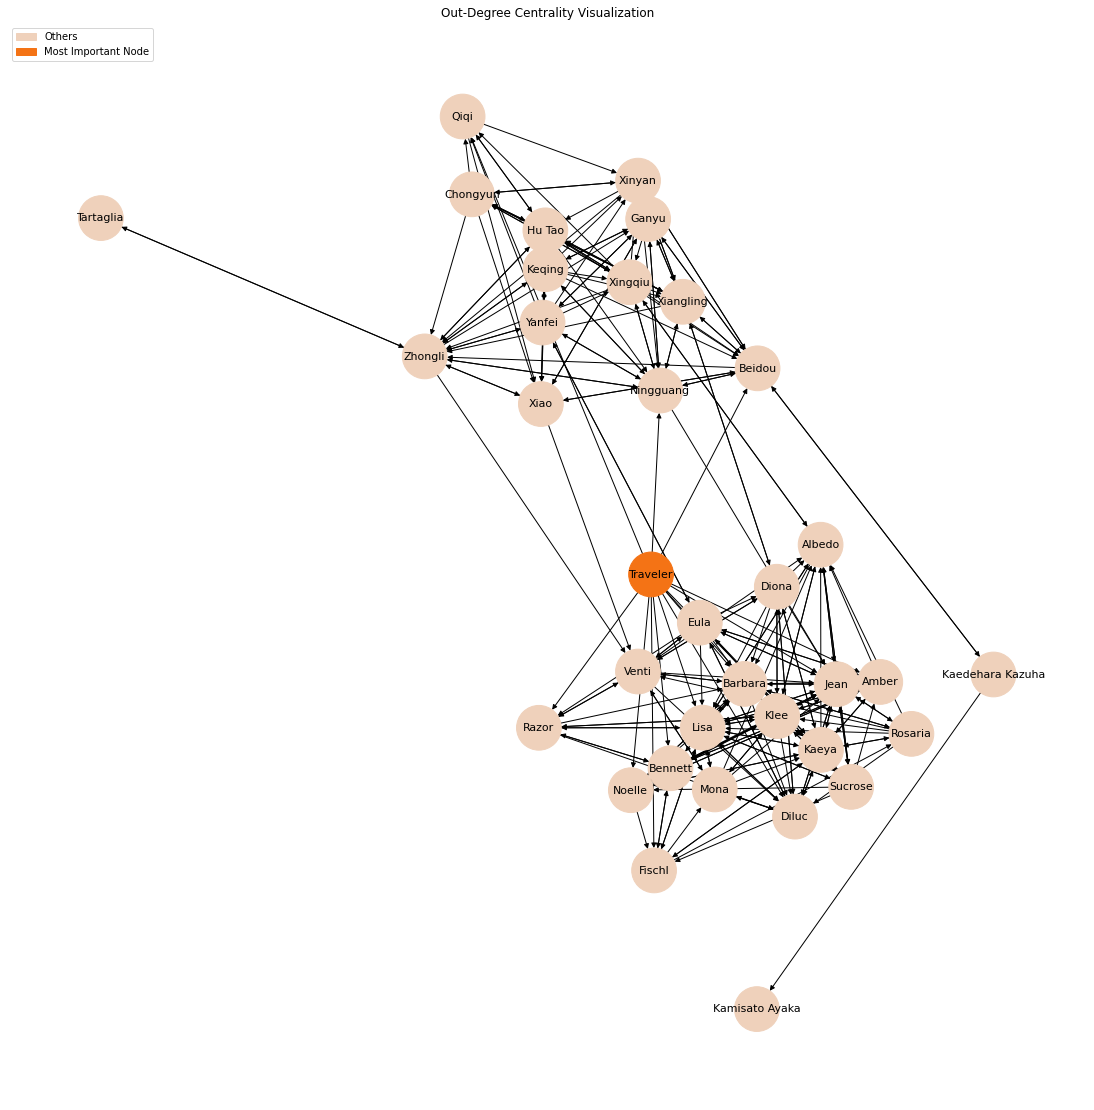

Wall time: 1.93 s


In [55]:
%%time

legend_tiles = [mpatches.Patch(color="#EFD1BB", label="Others"),
                mpatches.Patch(color="#F47315", label="Most Important Node")
               ]
node_colors = get_centrality_node_colors(directed_graph, "Traveler")
plot_genshin_network(directed_graph, node_colors, legend_tiles,
                     title="Out-Degree Centrality Visualization")